<a href="https://colab.research.google.com/github/amirrhseiin/Traffic-Signs-Recognition/blob/main/Traffic_sign_gray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import cv2
import numpy as np
import csv
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from keras.optimizers import SGD
from keras import Model
from keras.models import load_model
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
import random
from keras.callbacks import ReduceLROnPlateau
%matplotlib inline

In [ ]:
train_data = pd.read_pickle(r'C:\Users\Admin\Desktop\jupyter projects\data1\train.pickle')
test_data= pd.read_pickle(r'C:\Users\Admin\Desktop\jupyter projects\data1\test.pickle')
valid_data= pd.read_pickle(r'C:\Users\Admin\Desktop\jupyter projects\data1\valid.pickle')

Y_train= train_data['labels']
X_train= train_data['features']
Y_train=to_categorical(Y_train)

Y_valid= valid_data['labels']
X_valid= valid_data['features']
Y_valid=to_categorical(Y_valid)

Y_test= test_data['labels']
X_test= test_data['features']


Y_train.astype('uint8')
Y_valid.astype('uint8')
Y_test.astype('uint8')


array([16,  1, 38, ...,  6,  7, 10], dtype=uint8)

In [ ]:
train_img_list=[]
for i in range(34799):
    img=X_train[i]
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    train_img_list.append(img_gray)
   # plt.imshow(img_gray,cmap=plt.get_cmap('gray'))
Gray_X_train=np.array(train_img_list)

valid_img_list=[]
for i in range(4410):
    img=X_valid[i]
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    valid_img_list.append(img_gray)
   # plt.imshow(img_gray,cmap=plt.get_cmap('gray'))
Gray_X_valid=np.array(valid_img_list)

test_img_list=[]
for i in range(12630):
    img=X_test[i]
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    test_img_list.append(img_gray)
   # plt.imshow(img_gray,cmap=plt.get_cmap('gray'))
Gray_X_test=np.array(test_img_list)


In [ ]:
X_train= Gray_X_train.astype('float64')
X_test= Gray_X_test.astype('float64')
X_valid= Gray_X_valid.astype('float64')

X_train=X_train/ 255.0
X_test=X_test/ 255.0
X_valid=X_valid/ 255.0

X_train=X_train.reshape(34799,32,32,1)        
X_valid=X_valid.reshape(4410,32,32,1)

In [ ]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1)  

In [ ]:
X_train_data = datagen.flow(X_train, y=Y_train, batch_size = 256)
X_valid_data = datagen.flow(X_valid, y=Y_valid, batch_size = 256)



In [ ]:
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=1)
checkpointer = ModelCheckpoint(filepath="gray_best_weights.hdf5", monitor = 'val_accuracy',mode="max",
                               verbose=1,save_best_only=True)

lrr= ReduceLROnPlateau(monitor='val_acc', factor=.01, patience=3, min_lr=1e-5) 

In [ ]:
input_model = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name = 'input_layer')

model1 = Conv2D(32,(5,5), activation='relu',name = 'Conv1_5')(input_model)
model1 = BatchNormalization(name = 'Bnorm1')(model1)
model1 = Conv2D(32,(5,5), activation='relu', padding='same',name= 'Conv2_5')(model1)
model1 = BatchNormalization(name = 'Bnorm2')(model1)
model1 = MaxPooling2D((2, 2),name = 'MaxPool1')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv3_3')(model1)
model1 = BatchNormalization(name = 'Bnorm3')(model1)
model1 = Conv2D(64,(3,3), activation='relu' ,padding='same',name = 'Conv4_3')(model1)
model1 = BatchNormalization(name = 'Bnorm4')(model1)
model1 = AveragePooling2D((2, 2),name = 'AvgPool1')(model1)
model1 = Conv2D(128,(1,1), activation='relu' ,padding='valid',name = 'Conv5_1')(model1)
model1 = BatchNormalization(name = 'Bnorm5')(model1)
###########
model1 = Flatten(name = 'Flatten')(model1)
###########
model1 = Dense(units = 36, activation = 'relu')(model1)
model1 = Dropout(rate = 0.2)(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 20, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(units = 15, activation = 'relu')(model1)
model1 = BatchNormalization()(model1)
output = Dense(units = 43, activation = 'softmax' , name='preds')(model1)

model = Model(inputs= [input_model], outputs=[output])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
Conv1_5 (Conv2D)             (None, 28, 28, 32)        832       
_________________________________________________________________
Bnorm1 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
Conv2_5 (Conv2D)             (None, 28, 28, 32)        25632     
_________________________________________________________________
Bnorm2 (BatchNormalization)  (None, 28, 28, 32)        128       
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 14, 14, 32)        0         
_________________________________________________________________
Conv3_3 (Conv2D)             (None, 14, 14, 64)       

In [ ]:
#model =load_model('my_gary_model.h5') 
sgd = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_data, epochs= 10, validation_data= X_valid_data, verbose=1, callbacks=[es,checkpointer])

Epoch 1/10
136/136 [==============================] - ETA: 0s - loss: 3.3431 - accuracy: 0.1619
Epoch 00001: val_accuracy improved from -inf to 0.05624, saving model to gray_best_weights.hdf5
136/136 [==============================] - 165s 1s/step - loss: 3.3431 - accuracy: 0.1619 - val_loss: 3.6715 - val_accuracy: 0.0562
Epoch 2/10
136/136 [==============================] - ETA: 0s - loss: 2.0545 - accuracy: 0.4602
Epoch 00002: val_accuracy improved from 0.05624 to 0.15760, saving model to gray_best_weights.hdf5
136/136 [==============================] - 176s 1s/step - loss: 2.0545 - accuracy: 0.4602 - val_loss: 3.2569 - val_accuracy: 0.1576
Epoch 3/10
136/136 [==============================] - ETA: 0s - loss: 1.2827 - accuracy: 0.6396
Epoch 00003: val_accuracy improved from 0.15760 to 0.53900, saving model to gray_best_weights.hdf5
136/136 [==============================] - 175s 1s/step - loss: 1.2827 - accuracy: 0.6396 - val_loss: 1.7522 - val_accuracy: 0.5390
Epoch 4/10
136/136 [==

In [ ]:
model.save_weights('my_gary_weights.h5') 
model.save('my_gary_model.h5') 

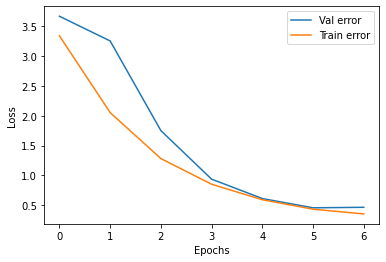

In [ ]:
val_loss = history.history['val_loss']
loss = history.history['loss']

plt.plot(val_loss)
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Val error','Train error'], loc='upper right')
plt.savefig('gary_plot_error.png')
plt.show()

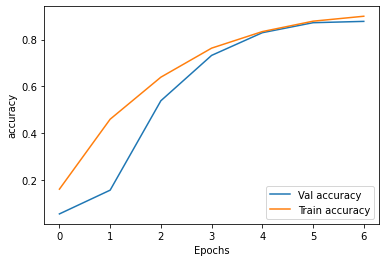

In [ ]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.plot(val_accuracy)
plt.plot(accuracy)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['Val accuracy','Train accuracy'], loc='lower right')
plt.savefig( 'gray_plot_accuracy.png')
plt.show()

In [ ]:
Y_pred = model.predict(X_test)

In [ ]:
Y_pred=np.argmax(Y_pred, axis=1)
Y_pred

array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [ ]:
Y_test

array([16,  1, 38, ...,  6,  7, 10], dtype=uint8)

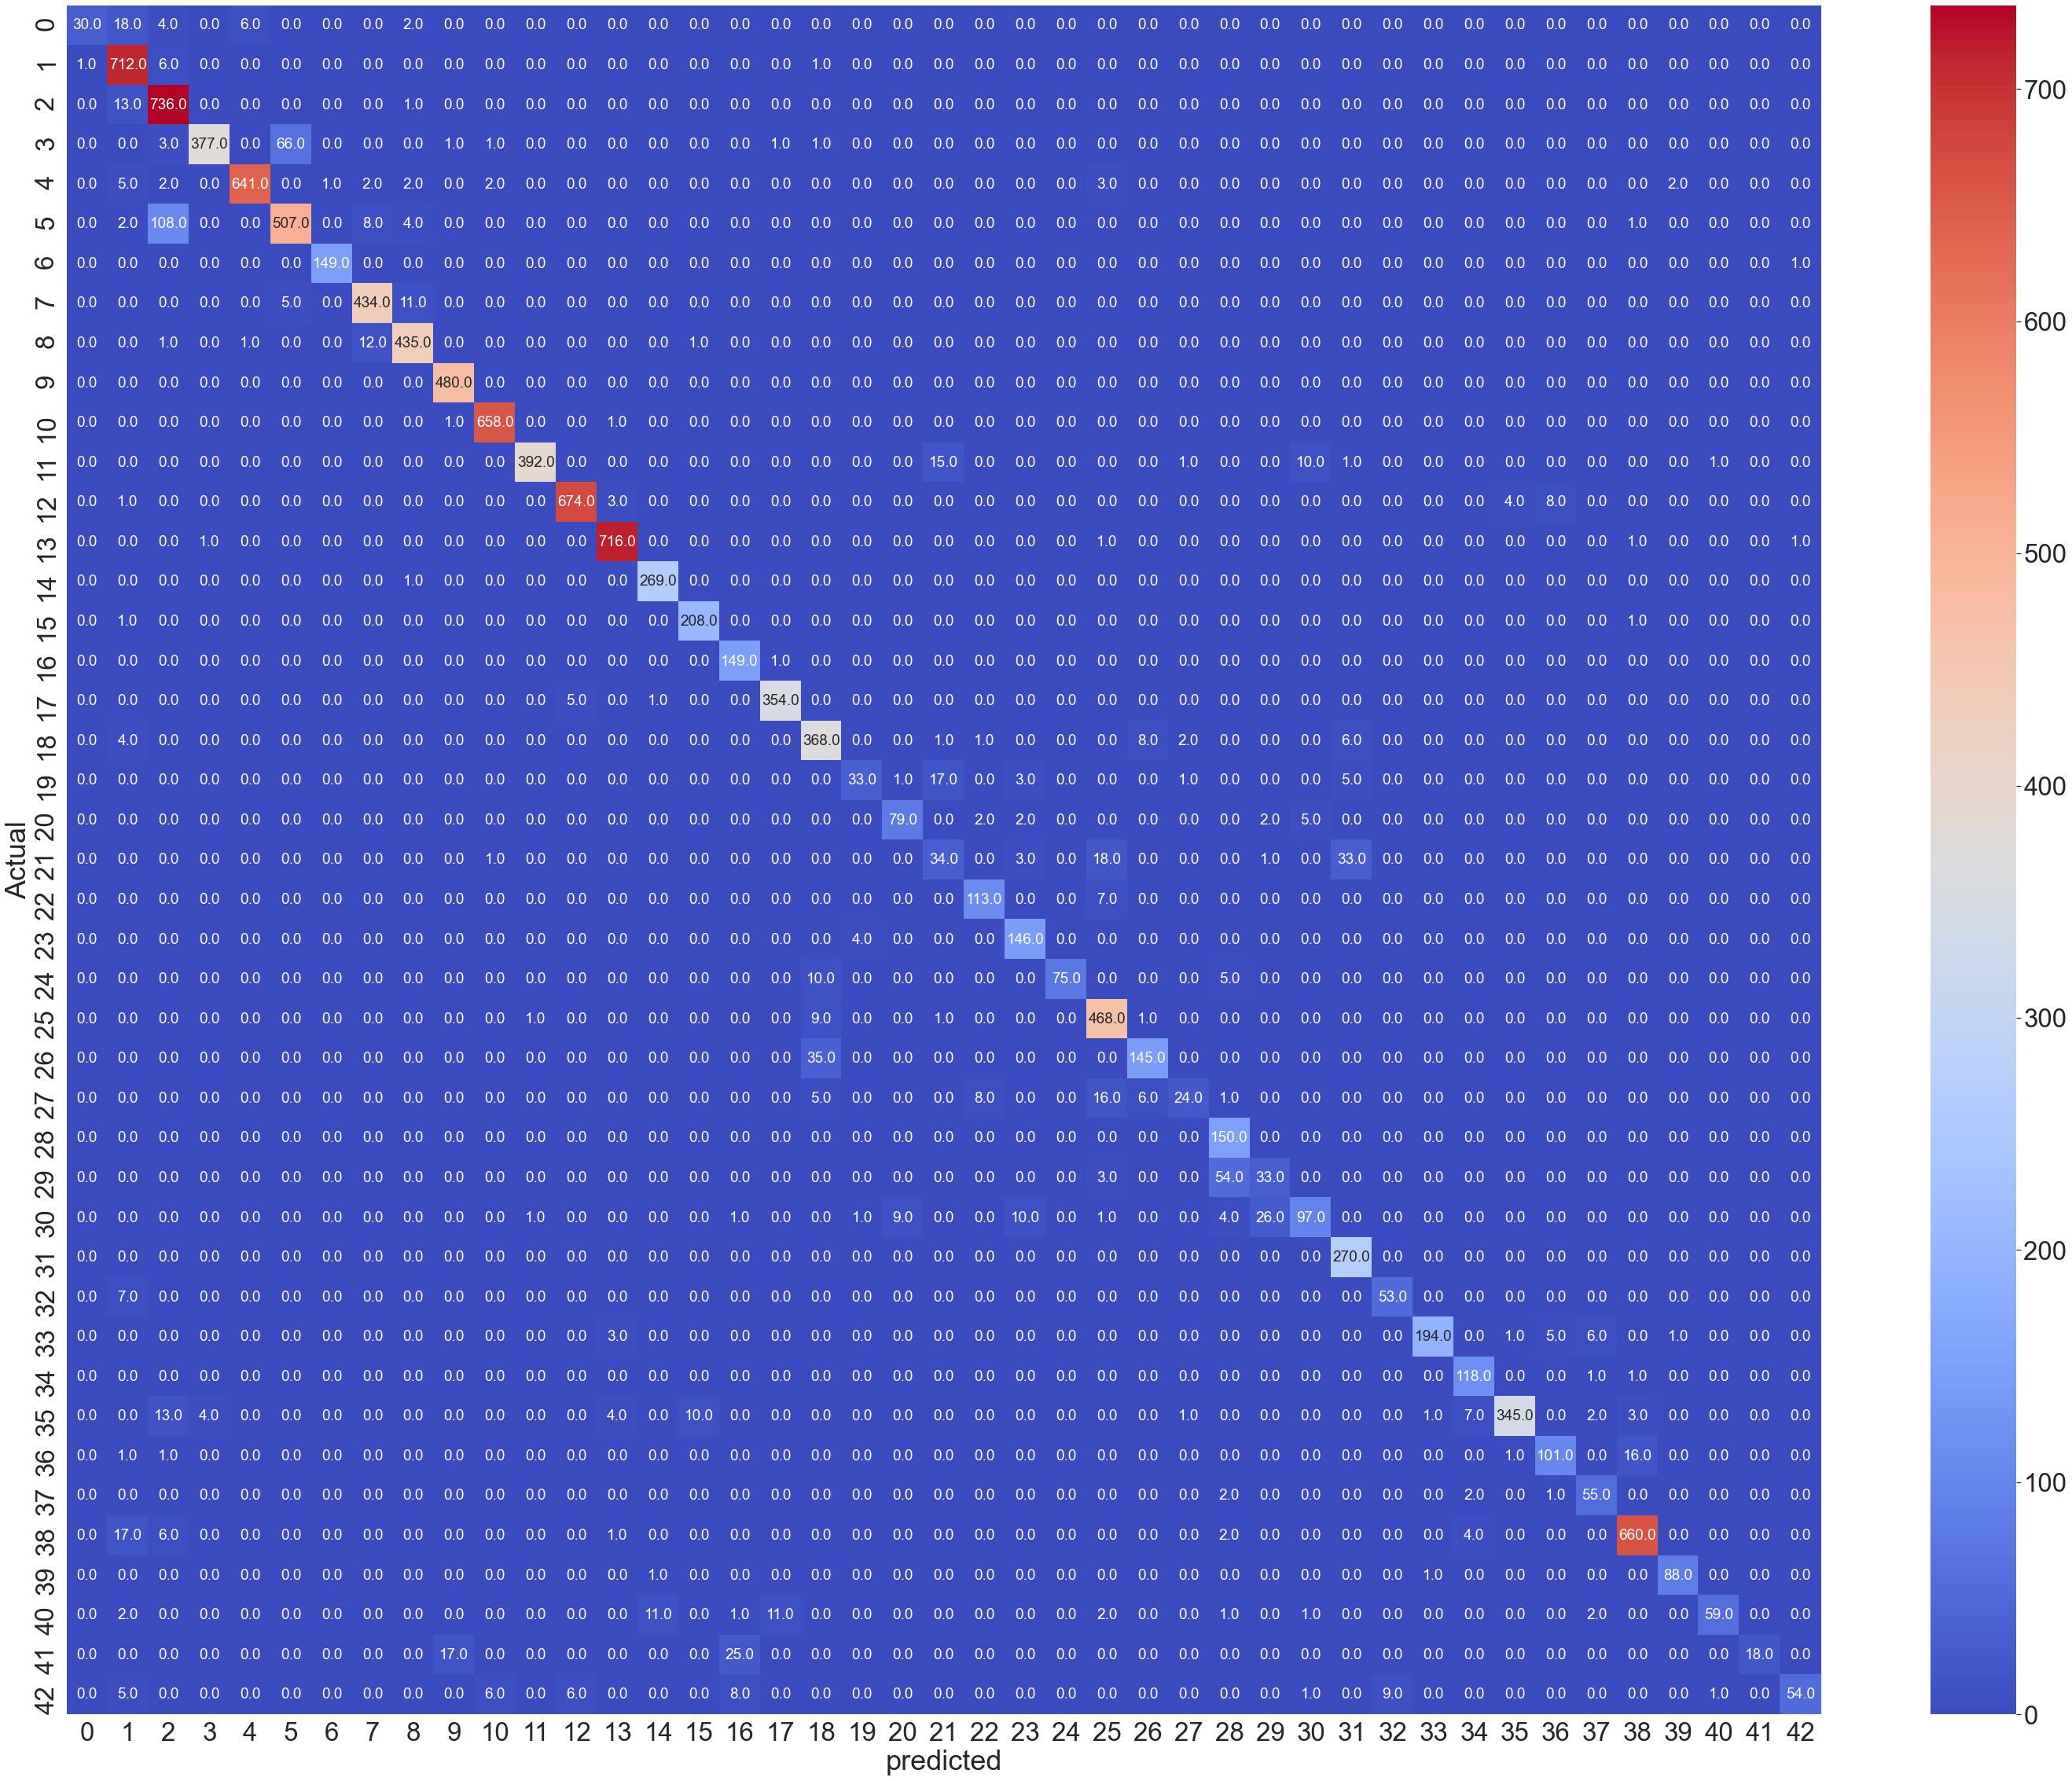

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
true=[]
pr=[]
for i in range(43):
    true.append(i)
    pr.append(i)
#arg_Y_test=np.argmax(Y_test,axis=1)
ddata=confusion_matrix(Y_test,Y_pred)
df=pd.DataFrame(ddata, columns=np.unique(true), index=np.unique(true))
df.index.name='Actual'
df.columns.name='predicted'
plt.figure(figsize=(50,40))
sns.set(font_scale=3)
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".1f", annot_kws={'size':19})

plt.savefig('gray_confusion_heatmap.png')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
acc_score=accuracy_score(Y_test, Y_pred)
acc_score

0.9264449722882027

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.97      0.50      0.66        60
           1       0.90      0.99      0.94       720
           2       0.84      0.98      0.90       750
           3       0.99      0.84      0.91       450
           4       0.99      0.97      0.98       660
           5       0.88      0.80      0.84       630
           6       0.99      0.99      0.99       150
           7       0.95      0.96      0.96       450
           8       0.95      0.97      0.96       450
           9       0.96      1.00      0.98       480
          10       0.99      1.00      0.99       660
          11       0.99      0.93      0.96       420
          12       0.98      0.98      0.98       690
          13       0.98      0.99      0.99       720
          14       0.95      1.00      0.97       270
          15       0.95      0.99      0.97       210
          16       0.81      0.99      0.89       150
          17       0.96    